# Science Radar
Aplicación para la detección automática de frentes de investigación.

In [10]:
%colors lightbg
%matplotlib inline
import pandas
from commands.network_generation import *
from commands.network_analysis import *
from commands.europe_pmc_harvester import *
from commands.burst_detection import *
from utils.fulltext_downloader import download_fulltext
from utils.bioportal_api import annotate_text
from utils.europe_pmc_api import get_paper_keywords
from utils import mongodb_access
from joblib import delayed, Parallel
import logging
import click_log
import matplotlib
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN

## Recolección de datos

### Parámetros para la recolección de datos

In [11]:
dataset_name = 'zika'
keywords = ['ZIKA', 'ZIKAV']
pmids = []
include_citing_papers = True
output_path = 'data/sciradar'
start_year = 2010
end_year = 2018
mongo_config = {
    'database': 'publications',
    'collection': 'zika',
    'host': 'mongodb',
    'port': 27017
}

### Creación de directorio de salida

In [12]:
output_path = output_path + '/' if not output_path.endswith('/') else output_path
output_path += dataset_name + '/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

### Recolección de datos desde [EuropePMC](https://europepmc.org/)

In [4]:
def get_paper_fulltext(reference, output_path):
    if os.path.isfile(output_path + 'json/' + reference['id'] + '.json'):
        with open(output_path + 'json/' + reference['id'] + '.json') as f:
            reference = json.load(f)
        return reference
    reference['fullText'] = download_fulltext(reference, output_path)
    return reference


def annotate_reference(reference, output_path):
    if os.path.isfile(output_path + 'json/' + reference['id'] + '.json'):
        with open(output_path + 'json/' + reference['id'] + '.json') as f:
            reference = json.load(f)
        return reference
    if reference['fullText'].strip() is not '':
        reference['annotations'] = annotate_text(reference['fullText'].strip())
    else:
        text = reference['title']
        text += reference['abstractText'] if 'abstractText' in reference else ''
        reference['annotations'] = annotate_text(text)
    with open(output_path + 'json/' + reference['id'] + '.json', 'w') as fp:
        json.dump(reference, fp, default=default, indent=4, sort_keys=True)

        
def annotate_citations(mongo_host, mongo_port, database, collection, reference):
    for index, citation in enumerate(reference['references']):
        if 'annotations' in citation:
            return
        text = ''
        if 'context' in citation and citation['context'].strip() is not '':
            text = citation['context'].strip()
        if 'title' in citation:
            text += ' ' + citation['title']
        if text == '':
            return
        reference['references'][index]['annotations'] = annotate_text(text)
        mongodb_access.update_document(mongo_host, mongo_port, database, collection, reference)

        
def get_citations_keywords(mongo_host, mongo_port, database, collection, reference):
    for index, citation in enumerate(reference['references']):
        if 'keywords' in citation:
            return
        if 'source' in citation and citation['source'] == 'MED' and 'id' in citation:
            reference['references'][index]['keywords'] = get_paper_keywords(citation['id'])
            mongodb_access.update_document(mongo_host, mongo_port, database, collection, reference)


def default(o):
    if type(o) is datetime.date or type(o) is datetime.datetime:
        return o.isoformat()
    
def get_references_from_mongo(mongo_host, mongo_port, database, collection):
    return list(mongodb_access.get_all(mongo_host, mongo_port, database, collection))


def get_citation_context(mongo_host, mongo_port, database, collection, reference, output_path):
    if 'pmcid' not in reference:
        return
    nxml_file_name = output_path + 'xml/' + reference['pmcid'] + '.nxml'
    if not os.path.isfile(nxml_file_name):
        return
    
    with open(nxml_file_name, 'r') as xml_file:
        xml_text = xml_file.read()
        xml_text = xml_text.replace('\n', ' ').replace('<sup>', '&lt;').replace('</sup>', '&gt;').replace('<italic>', '').replace('</italic>', '')
        soup = BeautifulSoup(xml_text, 'xml')
        has_change = False
        for index, citation in enumerate(reference['references']):
            if 'id' not in citation or citation['id'] == '':
                return
            cites_pmid = citation['id']
            ref_list_elem = soup.find('ref-list')
            if ref_list_elem:
                pub_id_elem = ref_list_elem.find('pub-id', {"pub-id-type": "pmid"}, text=cites_pmid)
                if pub_id_elem:
                    citation_elem = pub_id_elem.parent
                    if citation_elem:
                        ref_elem = citation_elem.parent
                        if ref_elem.has_attr('id'):
                            ref_id = ref_elem['id']
                            citation = soup.find('xref', {'rid': ref_id})
                            if citation is not None and citation.findParent('p'):
                                citation_text = citation.findParent('p').text.replace('<' + citation.text + '>',
                                                                                      '[{}]'.format(cites_pmid))
                                citation_text = citation_text.replace('[' + citation.text + ']',
                                                                      '[{}]'.format(cites_pmid))
                                citation_text = citation_text.replace(citation.text + ',',
                                                                      '[{}]'.format(cites_pmid))
                                reference['references'][index]['context'] = citation_text
                                has_change = True
            if has_change:
                mongodb_access.update_document(mongo_host, mongo_port, database, collection, reference)
   
                                    
                                
                                    

In [ ]:
references = get_references_from_mongo(mongo_config['host'], mongo_config['port'], mongo_config['database'], mongo_config['collection'])
if len(references) == 0:
    click.secho("Harvesting papers", fg='yellow')
    references = harvest_papers_metadata(keywords, pmids, start_year, end_year, include_citing_papers=include_citing_papers)

    click.secho("Getting fulltext", fg='yellow')
    references = Parallel(n_jobs=25)(delayed(get_paper_fulltext)(reference, output_path) for reference in tqdm(references))

    if not os.path.exists(output_path + 'json/'):
        os.makedirs(output_path + 'json/')

    click.secho("Annotating papers", fg='yellow')
    Parallel(n_jobs=25)(delayed(annotate_reference)(reference, output_path) for reference in tqdm(references))

    mongodb_access.save_directory(output_path + 'json/', 'publications', dataset_name, 'mongodb')
    references = get_references_from_mongo(mongo_config['host'], mongo_config['port'], mongo_config['database'], mongo_config['collection'])

In [ ]:
Parallel(n_jobs=16)(delayed(get_citation_context)(mongo_config['host'], mongo_config['port'], mongo_config['database'], mongo_config['collection'], reference, output_path) for reference in tqdm(references))

In [ ]:
reference_cursor = mongodb_access.get_all(mongo_config['host'], mongo_config['port'], mongo_config['database'], mongo_config['collection'])
Parallel(n_jobs=16)(delayed(annotate_citations)(mongo_config['host'], mongo_config['port'], mongo_config['database'], mongo_config['collection'], reference) for reference in tqdm(reference_cursor))


In [ ]:
reference_cursor = mongodb_access.get_all(mongo_config['host'], mongo_config['port'], mongo_config['database'], mongo_config['collection'])
Parallel(n_jobs=16)(delayed(get_citations_keywords)(mongo_config['host'], mongo_config['port'], mongo_config['database'], mongo_config['collection'], reference) for reference in tqdm(reference_cursor))


## Análisis de redes

In [ ]:
if not os.path.exists(output_path + 'gt/'):
    os.makedirs(output_path + 'gt/')

### Generación Red de Co-autoría

In [13]:
coauthorship_networks = generate_co_authorship_networks_incremental('', 'zika', 2010, 2018, output_path=output_path + 'gt/',
                                            mongo_config=mongo_config, save=True, use_cache=True)

   Generating network for range 2010-1 to 2010-1
   Generating network for range 2010-1 to 2010-2
   Generating network for range 2010-1 to 2010-3
   Generating network for range 2010-1 to 2010-4
   Generating network for range 2010-1 to 2010-5
   Generating network for range 2010-1 to 2010-6
   Generating network for range 2010-1 to 2010-7
   Generating network for range 2010-1 to 2010-8
   Generating network for range 2010-1 to 2010-9
   Generating network for range 2010-1 to 2010-10
   Generating network for range 2010-1 to 2010-11
   Generating network for range 2010-1 to 2010-12
   Generating network for range 2010-1 to 2011-1
   Generating network for range 2010-1 to 2011-2
   Generating network for range 2010-1 to 2011-3
   Generating network for range 2010-1 to 2011-4
   Generating network for range 2010-1 to 2011-5
   Generating network for range 2010-1 to 2011-6
   Generating network for range 2010-1 to 2011-7
   Generating network for range 2010-1 to 2011-8
   Generating net

In [14]:
coauthorship_analysis = analyse_networks(coauthorship_networks, output_path + 'gt/co-authorship-json')

       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-7 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-8 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-9 network
       Getting degree histogram
       G

       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-8 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-9 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-10 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
 

       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-10 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-11 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-12 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       

   Analysing 2010-1 to 2016-11 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2016-12 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2017-1 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2017-2 network


dict_keys(['2010-1 to 2010-7', '2010-1 to 2010-8', '2010-1 to 2010-9', '2010-1 to 2010-10', '2010-1 to 2010-11', '2010-1 to 2010-12', '2010-1 to 2011-1', '2010-1 to 2011-2', '2010-1 to 2011-3', '2010-1 to 2011-4', '2010-1 to 2011-5', '2010-1 to 2011-6', '2010-1 to 2011-7', '2010-1 to 2011-8', '2010-1 to 2011-9', '2010-1 to 2011-10', '2010-1 to 2011-11', '2010-1 to 2011-12', '2010-1 to 2012-1', '2010-1 to 2012-2', '2010-1 to 2012-3', '2010-1 to 2012-4', '2010-1 to 2012-5', '2010-1 to 2012-6', '2010-1 to 2012-7', '2010-1 to 2012-8', '2010-1 to 2012-9', '2010-1 to 2012-10', '2010-1 to 2012-11', '2010-1 to 2012-12', '2010-1 to 2013-1', '2010-1 to 2013-2', '2010-1 to 2013-3', '2010-1 to 2013-4', '2010-1 to 2013-5', '2010-1 to 2013-6', '2010-1 to 2013-7', '2010-1 to 2013-8', '2010-1 to 2013-9', '2010-1 to 2013-10', '2010-1 to 2013-11', '2010-1 to 2013-12', '2010-1 to 2014-1', '2010-1 to 2014-2', '2010-1 to 2014-3', '2010-1 to 2014-4', '2010-1 to 2014-5', '2010-1 to 2014-6', '2010-1 to 2014-7

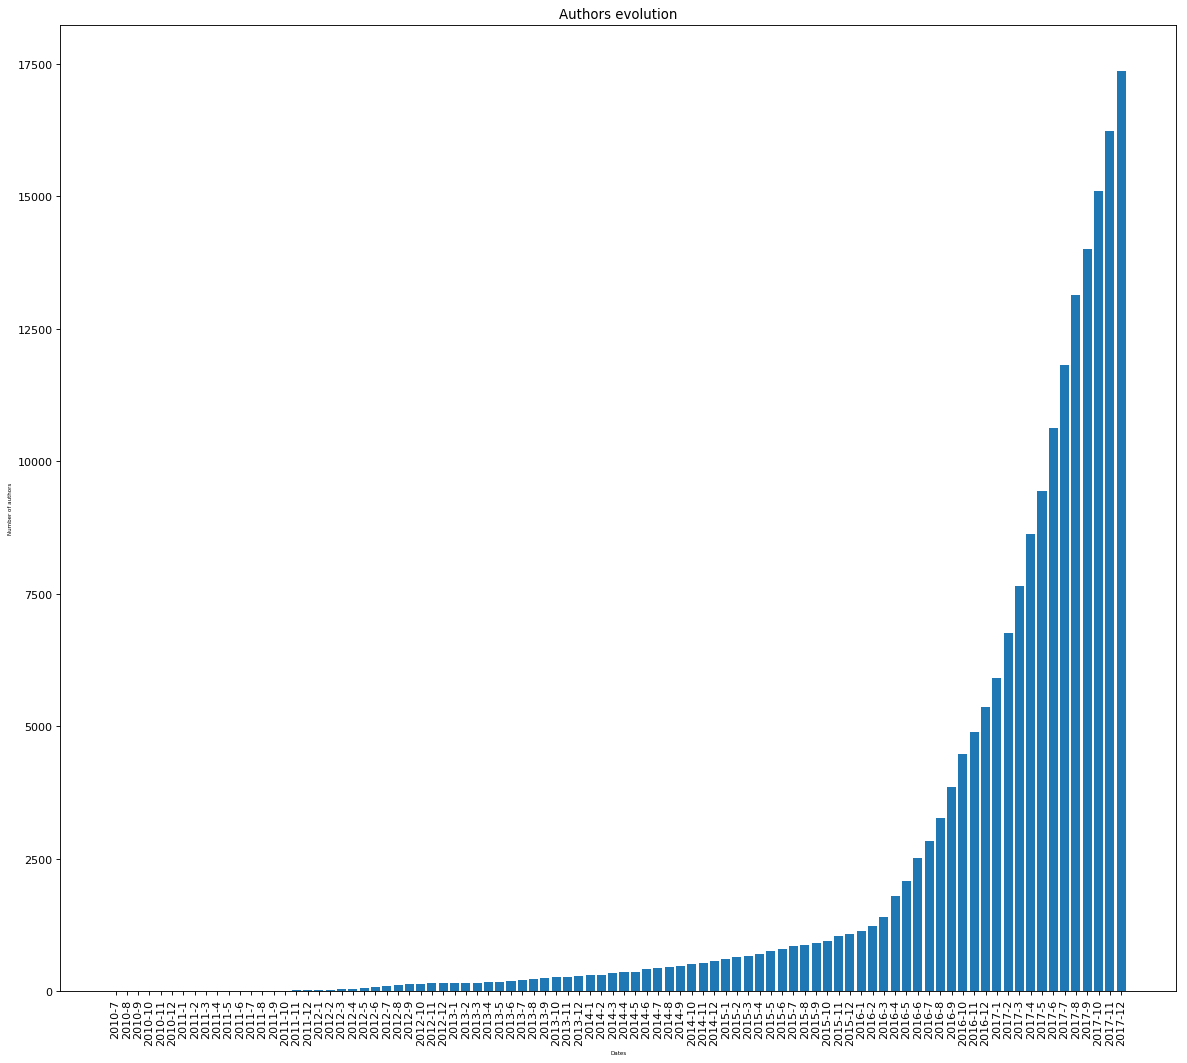

In [15]:
dates = coauthorship_analysis.keys()
values = [analysis['vertex_count'] for analysis in coauthorship_analysis.values()]
print(dates)
print(values)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(coauthorship_analysis.keys(), values)
plt.xlabel('Dates', fontsize=5)
plt.ylabel('Number of authors', fontsize=5)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.title('Authors evolution')
plt.show()

[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 3.2, 3.2, 3.2, 3.2, 3.2, 22.2, 22.2, 22.2, 22.2, 26.8, 31.3, 37.9, 43.0, 57.7, 65.5, 72.4, 74.0, 78.5, 78.5, 78.5, 78.5, 81.2, 86.0, 88.3, 98.1, 99.7, 104.9, 117.3, 121.7, 126.3, 131.2, 137.6, 140.5, 159.7, 180.0, 181.6, 204.9, 213.0, 218.2, 227.8, 244.1, 264.3, 274.9, 289.6, 303.5, 313.7, 323.1, 362.2, 376.8, 407.0, 413.4, 424.0, 454.9, 638.2, 654.5, 687.3, 719.8, 796.6, 1197.9, 1331.0, 1601.8, 1775.4, 1992.5, 2401.5, 3530.2, 3744.5, 4036.7, 4399.3, 5256.8, 6120.8, 6795.6, 7597.7, 10302.6, 14089.1, 15754.6, 16384.3, 17180.3, 17977.9, 18639.7]


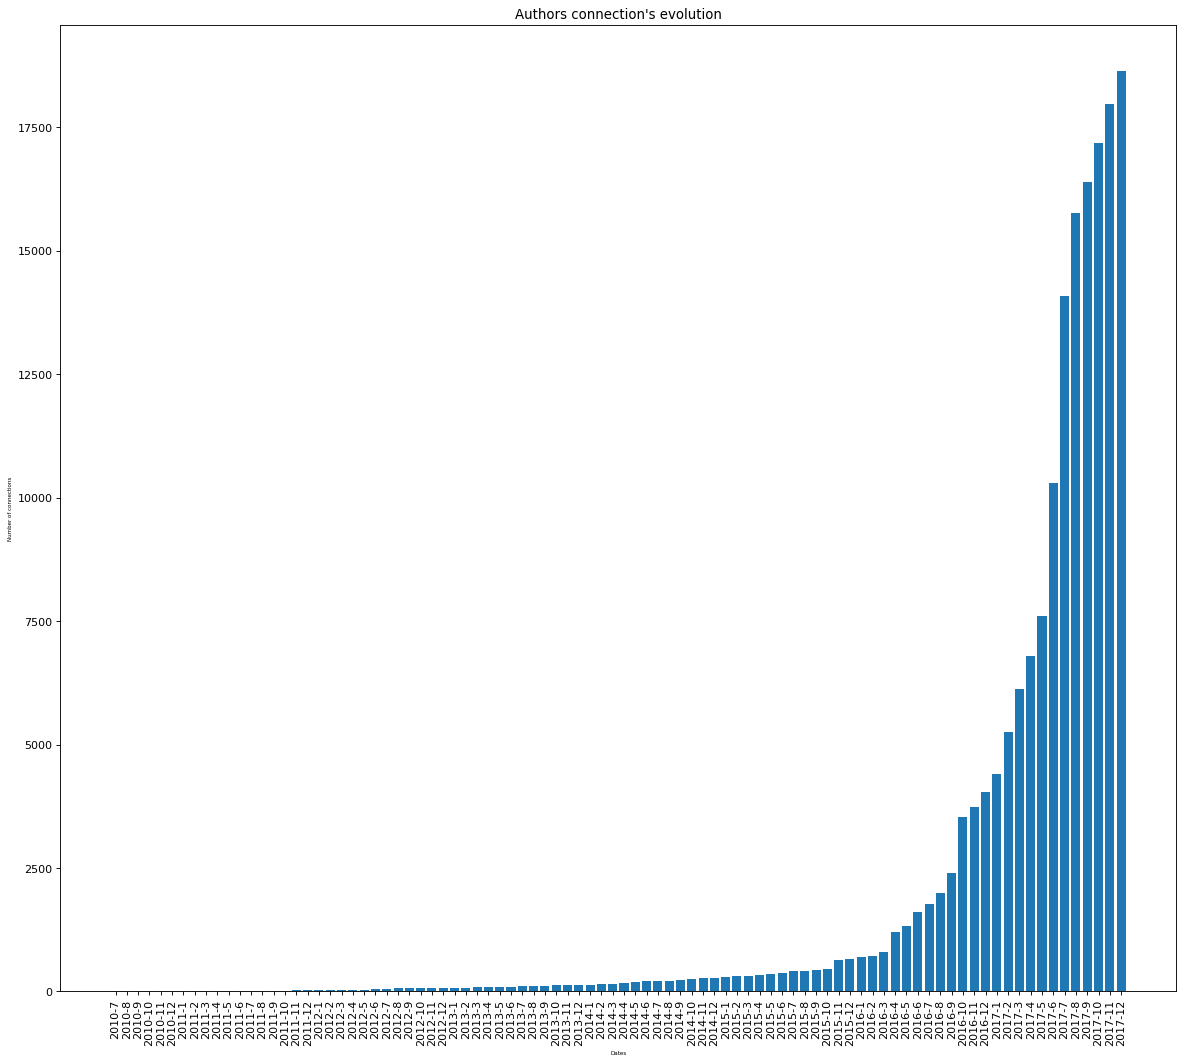

In [18]:
dates = coauthorship_analysis.keys()
values = [analysis['edge_count']/10 for analysis in coauthorship_analysis.values()]
print(values)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(coauthorship_analysis.keys(), values)
plt.xlabel('Dates', fontsize=5)
plt.ylabel('Number of connections', fontsize=5)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.title('Authors connection\'s evolution')
plt.show()

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9636005902606984, 0.8799437863882754, 0.8901946382666177, 0.8961444946161862, 0.9167826328973003, 0.9256588761810045, 0.9033730379605922, 0.9040141545947141, 0.8847897122377991, 0.8847897122377991, 0.8847897122377991, 0.8847897122377991, 0.875268158136684, 0.8730127382245483, 0.8706486958208087, 0.84207343412527, 0.8422363448986603, 0.8458892617449665, 0.8466341760584831, 0.8487133984028394, 0.8366925432661492, 0.8399413653497138, 0.8279562769128851, 0.8264926590538336, 0.8525072110051032, 0.8390078498769102, 0.8356818286133934, 0.8260993834469805, 0.8203561937249614, 0.8225522078125612, 0.8215247998178438, 0.8213326738270209, 0.8206129221159477, 0.8180868904850805, 0.8231327800829875, 0.8264559898969133, 0.8256233877901977, 0.8251392248410868, 0.8257623199576087, 0.8282569149680489, 0.8170525005900148, 0.8181179476261443, 0.8175675675675675, 0.8106835152211372, 0.9073994109344488, 0.

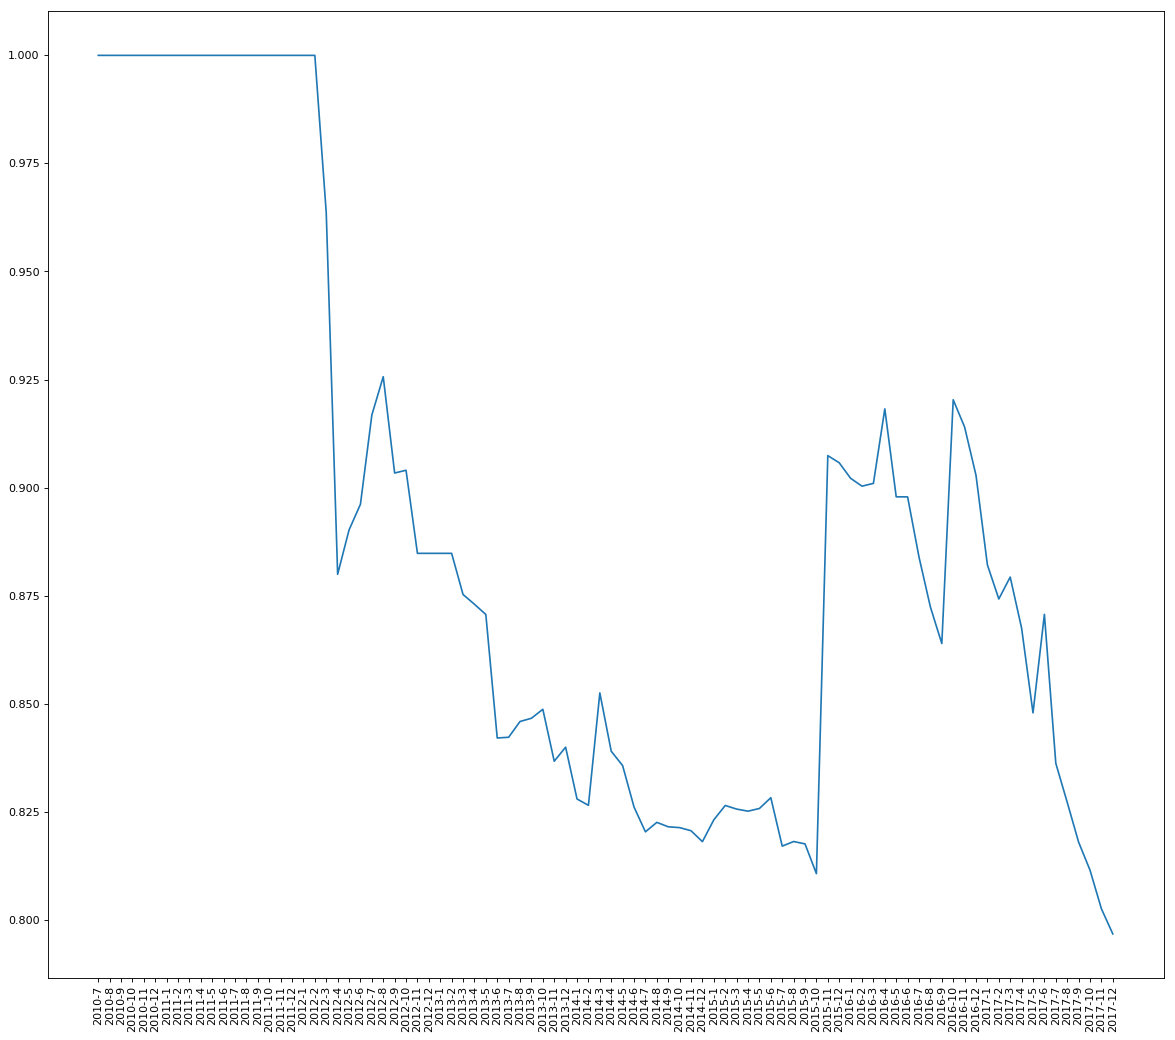

In [16]:
dates = coauthorship_analysis.keys()
values = [analysis['clustering_coefficient'][0] for analysis in coauthorship_analysis.values()]
print(values)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

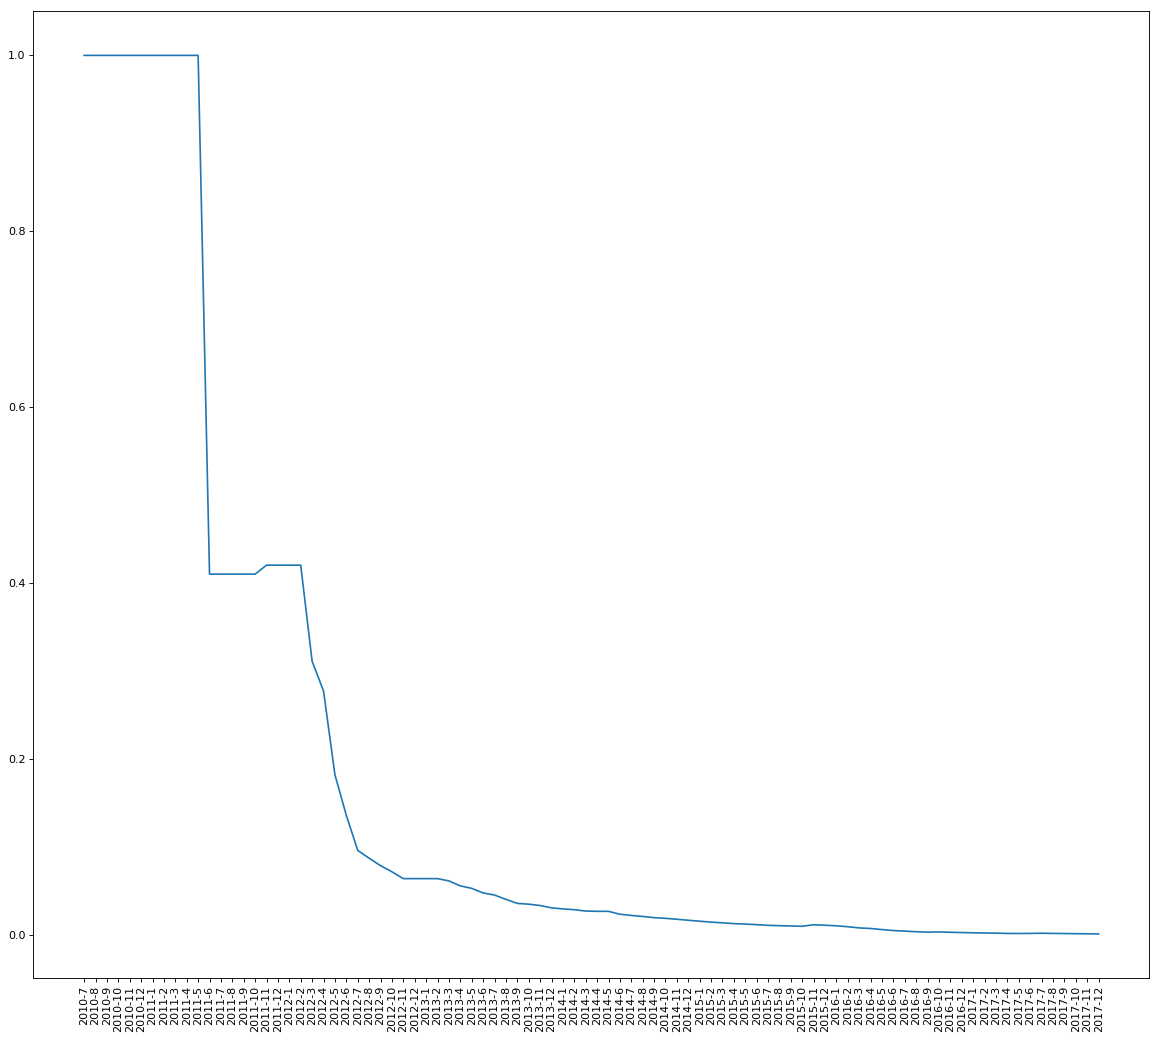

In [7]:
dates = coauthorship_analysis.keys()
values = [analysis['density'] for analysis in coauthorship_analysis.values()]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

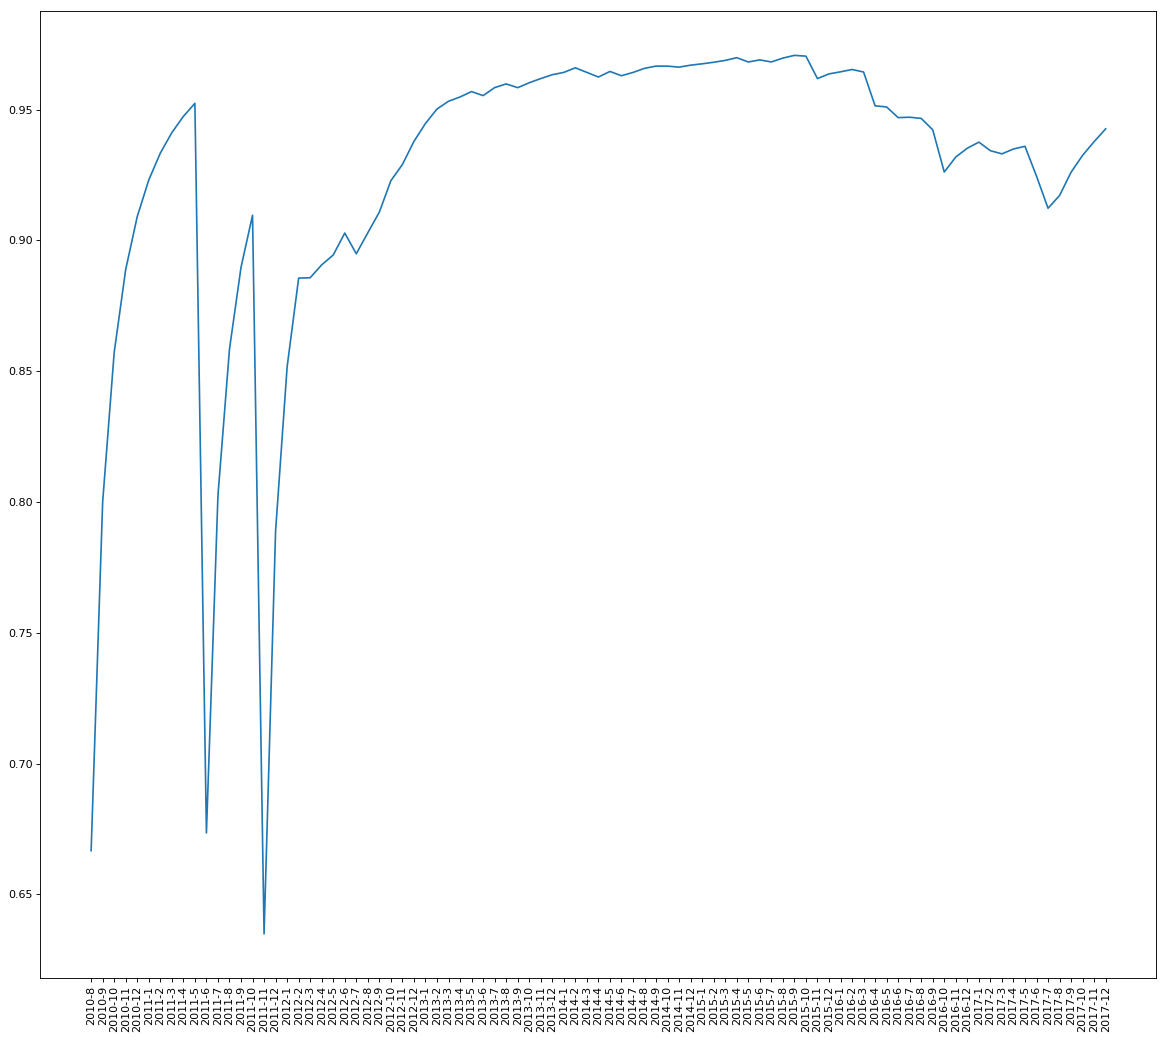

In [8]:
dates = list(coauthorship_analysis.keys())[1:]
values = [analysis['similarity_year_before'] for analysis in list(coauthorship_analysis.values())[1:]]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

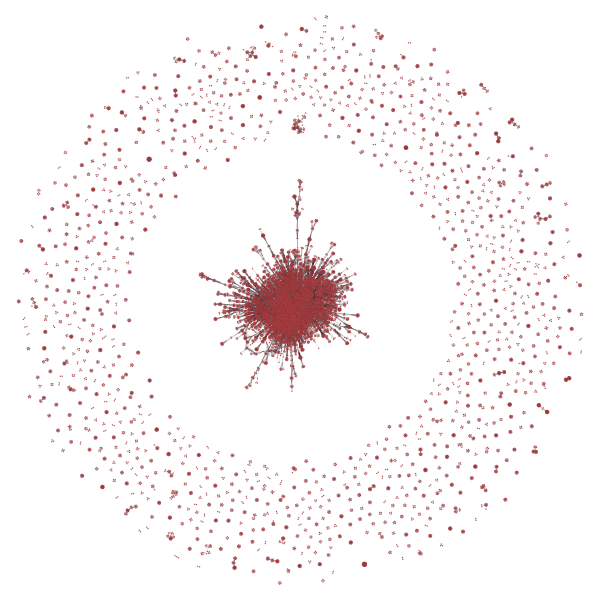

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f65f48bf2b0, at 0x7f65f2df6438>

In [9]:
graph_draw(coauthorship_networks['2010-1 to 2017-12'])

### Generación Red de Co-citación

In [5]:
co_citation_networks = get_co_citation_network_incremental('', 'zika', 2010, 2018, output_path=output_path + 'gt/',
                                            mongo_config=mongo_config, save=True, use_cache=True)

   Generating network for range 2010-1 to 2010-1
   Generating network for range 2010-1 to 2010-2
   Generating network for range 2010-1 to 2010-3
   Generating network for range 2010-1 to 2010-4
   Generating network for range 2010-1 to 2010-5
   Generating network for range 2010-1 to 2010-6
   Generating network for range 2010-1 to 2010-7
   Generating network for range 2010-1 to 2010-8
   Generating network for range 2010-1 to 2010-9
   Generating network for range 2010-1 to 2010-10
   Generating network for range 2010-1 to 2010-11
   Generating network for range 2010-1 to 2010-12
   Generating network for range 2010-1 to 2011-1
   Generating network for range 2010-1 to 2011-2
   Generating network for range 2010-1 to 2011-3
   Generating network for range 2010-1 to 2011-4
   Generating network for range 2010-1 to 2011-5
   Generating network for range 2010-1 to 2011-6
   Generating network for range 2010-1 to 2011-7
   Generating network for range 2010-1 to 2011-8
   Generating net

In [6]:
co_citation_analysis = analyse_networks(co_citation_networks, output_path + 'gt/co-citation.json')

       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-7 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-8 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2010-9 network
       Getting degree histogram
       G

       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-8 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-9 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2012-10 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
 

       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-10 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-11 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2014-12 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       

   Analysing 2010-1 to 2016-11 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2016-12 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2017-1 network
       Getting degree histogram
       Getting degree average
       Getting edge count
       Getting weight average
       Getting edge weight histogram
       Getting vertex count
       Getting density
       Getting clustering coefficient
       Getting similarity year before
   Analysing 2010-1 to 2017-2 network


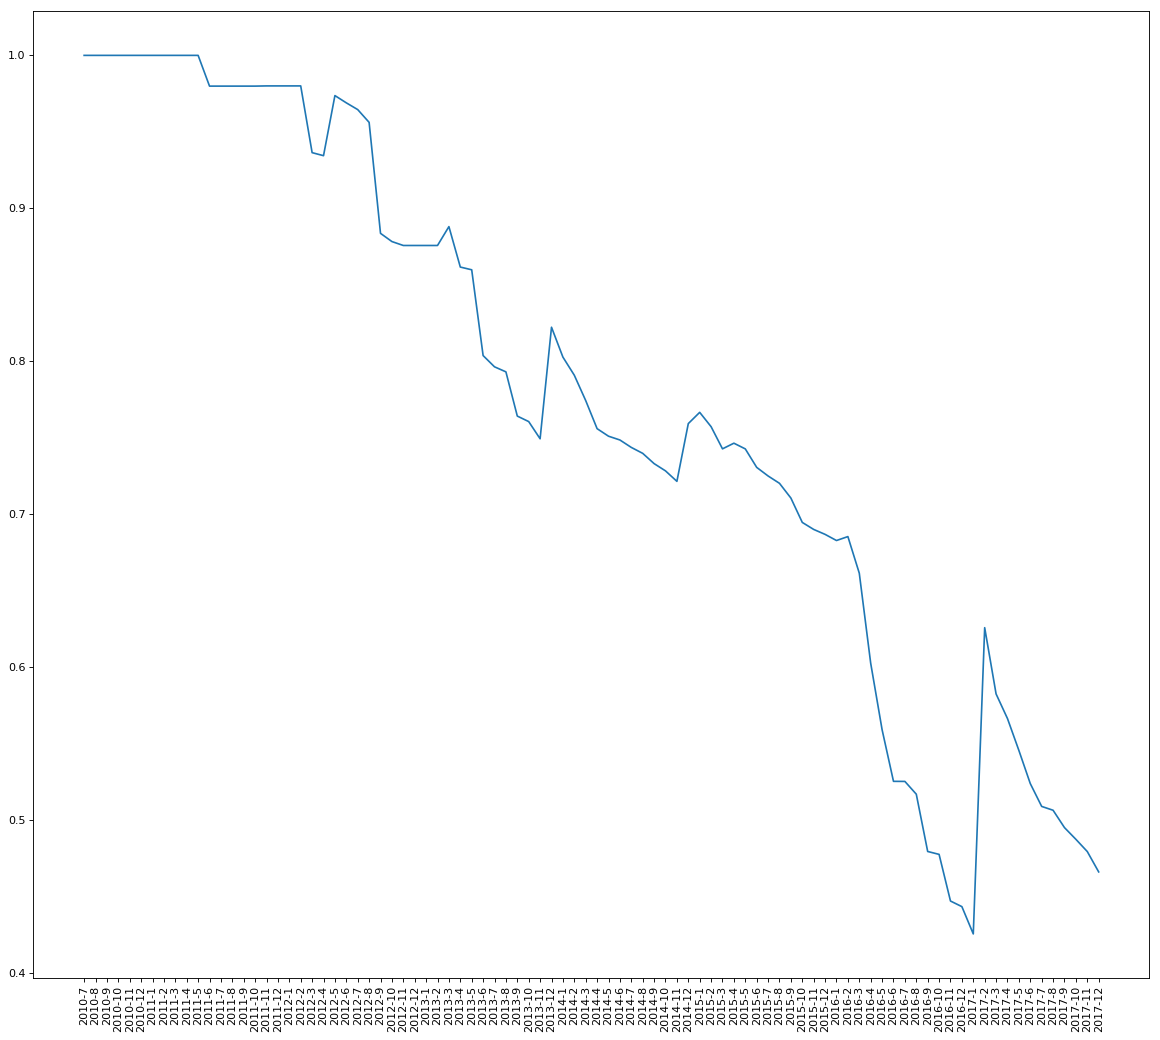

In [7]:
dates = co_citation_analysis.keys()
values = [analysis['clustering_coefficient'][0] for analysis in co_citation_analysis.values()]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

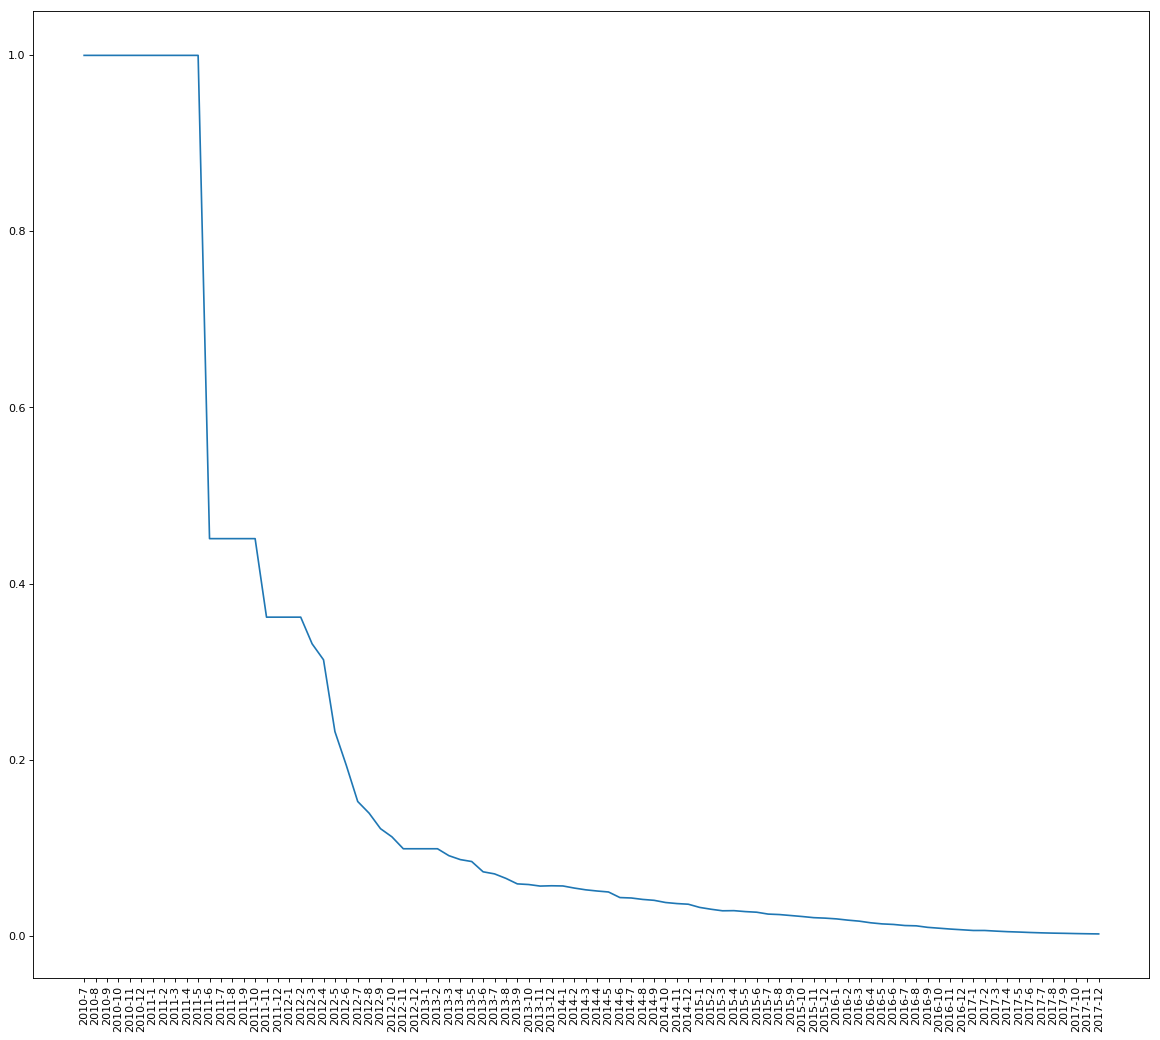

In [8]:
dates = co_citation_analysis.keys()
values = [analysis['density'] for analysis in co_citation_analysis.values()]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

In [ ]:
dates = list(co_citation_analysis.keys())[1:]
values = [analysis['similarity_year_before'] for analysis in list(co_citation_analysis.values())[1:]]
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, values)
plt.xticks(list(dates), [date.split(' to ')[1] for date in dates], rotation='vertical')
plt.show()

In [ ]:
graph_draw(co_citation_networks['2010-1 to 2014-12'])

In [ ]:
g = co_citation_networks['2010-1 to 2014-12']
g = GraphView(g, vfilt=label_largest_component(g))
ee, x, y = hits(g, g.edge_properties['weight'])
graph_draw(g, vertex_fill_color=x,
               vertex_size=prop_to_size(x, mi=5, ma=15),
               vcmap=matplotlib.cm.gist_heat,
               vorder=x)

In [ ]:
graph_draw(g, vertex_fill_color=y,
               vertex_size=prop_to_size(y, mi=5, ma=15),
               vcmap=matplotlib.cm.gist_heat,
               vorder=y)

In [ ]:
graph_draw(co_citation_networks['2010-1 to 2015-12'])

In [ ]:
g = co_citation_networks['2010-1 to 2015-12']
g = GraphView(g, vfilt=label_largest_component(g))
ee, x, y = hits(g, g.edge_properties['weight'])
graph_draw(g, vertex_fill_color=x,
               vertex_size=prop_to_size(x, mi=5, ma=15),
               vcmap=matplotlib.cm.gist_heat,
               vorder=x)

In [ ]:
graph_draw(g, vertex_fill_color=y,
               vertex_size=prop_to_size(y, mi=5, ma=15),
               vcmap=matplotlib.cm.gist_heat,
               vorder=y)

In [ ]:
graph_draw(co_citation_networks['2010-1 to 2016-12'])

In [ ]:
g = co_citation_networks['2010-1 to 2016-12']
g = GraphView(g, vfilt=label_largest_component(g))
ee, x, y = hits(g, g.edge_properties['weight'])
graph_draw(g, vertex_fill_color=x,
               vertex_size=prop_to_size(x, mi=5, ma=15),
               vcmap=matplotlib.cm.gist_heat,
               vorder=x)

In [ ]:
graph_draw(g, vertex_fill_color=y,
               vertex_size=prop_to_size(y, mi=5, ma=15),
               vcmap=matplotlib.cm.gist_heat,
               vorder=y)

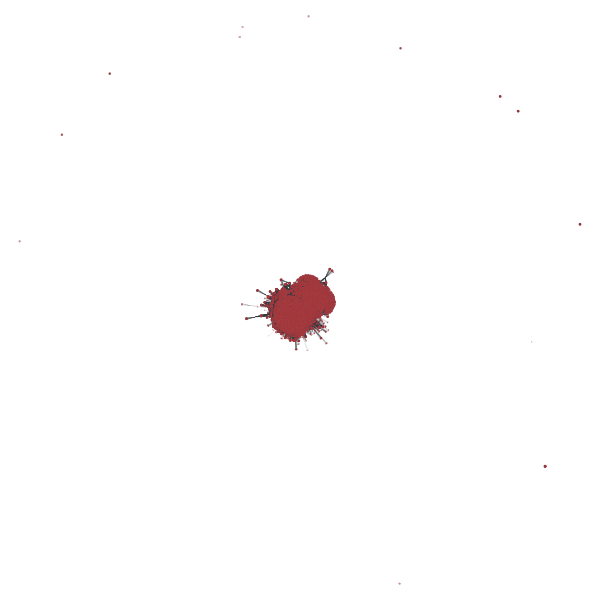

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f65f2cfbf60, at 0x7f65f2be7a58>

In [17]:
graph_draw(co_citation_networks['2010-1 to 2017-12'])

In [ ]:
g = co_citation_networks['2010-1 to 2017-12']
g = GraphView(g, vfilt=lambda v: g.vertex_properties['citedByCount'][v] > 10)
g = GraphView(g, vfilt=label_largest_component(g))
ee, x, y = hits(g, g.edge_properties['weight'])
graph_draw(g, vertex_fill_color=x,
               vertex_size=prop_to_size(x, mi=5, ma=15),
               vcmap=matplotlib.cm.gist_heat,
               vorder=x)

In [ ]:
graph_draw(g, vertex_fill_color=y,
               vertex_size=prop_to_size(y, mi=5, ma=15),
               vcmap=matplotlib.cm.gist_heat,
               vorder=y)

In [ ]:
g = co_citation_networks['2010-1 to 2014-12']
g_most = GraphView(g, vfilt=lambda v: g.vertex_properties['citedByCount'][v] > 1).copy()
g_most.purge_vertices()
g_most.save(output_path + 'gt/co-citation_most_cited_2014.xml.gz')

In [ ]:
references, index = mongodb_access.get_references_annotations('publications', 'zika', 'mongodb', 27017, 2010, 1, 2017, 12)
most_cited = mongodb_access.get_references_count('publications', 'zika', 'mongodb', 27017, 2010, 1, 2017, 12)
print(len(most_cited))
to_cluster = []
pmids_to_cluster = [] 
for i, pmid in enumerate(index):
    if pmid in most_cited:
        to_cluster.append(references[i])
        pmids_to_cluster.append(str(pmid))
t0 = time()
print('vectorizing')
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(to_cluster)
print("n_samples: %d, n_features: %d" % X.shape)
X = X.todense()
threshold = 0.5
Z = hierarchy.linkage(X, "average", metric="cosine")
C = hierarchy.fcluster(Z, threshold, criterion="distance")
dn = hierarchy.dendrogram(Z, labels=pmids_to_cluster)
plt.figure()
plt.show()
print(len(set(C)))
pmid_cluster_map = dict()
for i, label in enumerate(C):
    pmid_cluster_map[pmids_to_cluster[i]] = label
g_grouped = co_citation_networks['2010-1 to 2017-12']

group_prop = g_grouped.new_vertex_property("int")
g_grouped.vertex_properties['group'] = group_prop

for v in g_grouped.vertices():
    pmid = g_grouped.vertex_properties['label'][v]
    g_grouped.vertex_properties['group'][v] = pmid_cluster_map[pmid] if pmid in pmid_cluster_map else -1
g_grouped = GraphView(g_grouped, vfilt=lambda v: g_grouped.vertex_properties['group'][v] > -1 and  g_grouped.vertex_properties['group'][v] is not None).copy()
g_grouped.purge_vertices()
g_grouped.save(output_path + 'gt/clustered_2010_2017.xml.gz')



In [ ]:
references, index = mongodb_access.get_references_annotations('publications', 'zika', 'mongodb', 27017, 2010, 1, 2018, 1)
t0 = time()
print('vectorizing')
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(references)
print("n_samples: %d, n_features: %d" % X.shape)
db = DBSCAN(metric='cosine', eps=0.5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
print(len(unique_labels))
pmid_cluster_map = dict()
for i, label in enumerate(labels):
    pmid_cluster_map[index[i]] = label
g_grouped = co_citation_networks['2010-1 to 2017-12']

group_prop = g_grouped.new_vertex_property("int")
g_grouped.vertex_properties['group'] = group_prop

for v in g_grouped.vertices():
    pmid = g_grouped.vertex_properties['label'][v]
    g_grouped.vertex_properties['group'][v] = pmid_cluster_map[pmid] if pmid in pmid_cluster_map else -1
g_grouped = GraphView(g_grouped, vfilt=lambda v: g_grouped.vertex_properties['group'][v] > -1 and  g_grouped.vertex_properties['group'][v] is not None).copy()
g_grouped.purge_vertices()
g_grouped.save(output_path + 'gt/clustered_2010_2017.xml.gz')


### Generación Red de Co-aparación de las anotaciones

In [ ]:
cooccurrence_networks = get_co_occurrence_network_incremental('', 'zika', 2010, 2018, output_path=output_path + 'gt/',
                                                              mongo_config=mongo_config, save=True, use_cache=True)

## Análisis de ráfaga

### Ráfaga de palabras utilizando las anotaciones

### Ráfaga de palabras utilizando el texto completo

### Ráfaga de palabras utilizando título y abstract

### Ráfaga de palabras utilizando palabras clave

### Ráfaga de palabras utilizando MESH

## Detección de frentes de investigación

### Análisis del cambio en los autores

### Análisis del cambio en la interdisciplinariedad

### Análisis de ráfaga de palabras